In [25]:
# Import the libraries here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import roc_auc_score, roc_curve
from typing import Tuple

## Part A - Regularization

### A-1: Read Data

In [26]:
file_path = "Hitters-1.csv"
df = pd.read_csv(file_path)
df.head()
df.shape

(322, 21)

### A-2: Data Pre-processing

In [27]:
df = df.dropna()
print(df.shape)

features = df.drop(columns=['NewLeague','Player'])
labels = df['NewLeague']

numerical_cols = features.select_dtypes(include=['int64', 'float64'])
categorical_cols = features.select_dtypes(exclude=['int64', 'float64'])
categorical_encoded = pd.get_dummies(categorical_cols)
processed_data = pd.concat([numerical_cols, categorical_encoded], axis=1)
labels = labels.replace({'A': 0, 'N': 1})
processed_data

(263, 21)


AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  ...  \
1      315    81      7    24   38     39     14    3449    835      69  ...   
2      479   130     18    66   72     76      3    1624    457      63  ...   
3      496   141     20    65   78     37     11    5628   1575     225  ...   
4      321    87     10    39   42     30      2     396    101      12  ...   
5      594   169      4    74   51     35     11    4408   1133      19  ...   
..     ...   ...    ...   ...  ...    ...    ...     ...    ...     ...  ...   
317    497   127      7    65   48     37      5    2703    806      32  ...   
318    492   136      5    76   50     94     12    5511   1511      39  ...   
319    475   126      3    61   43     52      6    1700    433       7  ...   
320    573   144      9    85   60     78      8    3198    857      97  ...   
321    631   170      9    77   44     31     11    4908   1457      30  ...   

     CRBI  CWalks  PutOuts  Assists  Errors  Salary  League_A  League_N  \
1     414     375      632       43      10   475.0         0         1   
2     266     263      880       82      14   480.0         1         0   
3     838     354      200       11       3   500.0         0         1   
4      46      33      805       40       4    91.5         0         1   
5     336     194      282      421      25   750.0         1         0   
..    ...     ...      ...      ...     ...     ...       ...       ...   
317   311     138      325        9       3   700.0         0         1   
318   451     875      313      381      20   875.0         1         0   
319    93     146       37      113       7   385.0         1         0   
320   420     332     1314      131      12   960.0         1         0   
321   357     249      408        4       3  1000.0         1         0   

     Division_E  Division_W  
1             0           1  
2             0           1  
3             1           0  
4             1           0  
5             0           1  
..          ...         ...  
317           1           0  
318           1           0  
319           0           1  
320           1           0  
321           0           1  

[263 rows x 21 columns]

### A-3: Splitting Data

In [28]:
X = processed_data.values  #input features:X
y = labels.values  #output: y

# Split the data into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Verify the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (184, 21)
X_val shape: (39, 21)
X_test shape: (40, 21)
y_train shape: (184,)
y_val shape: (39,)
y_test shape: (40,)


### A-4: Train Ridge

In [9]:
def train_ridge( x_train: np.ndarray, y_train:np.ndarray, x_val: np.ndarray, y_val: np.ndarray, max_iter: int = int(1e8))-> dict:
    '''
        Instantiate an object of Ridge Regression, train the model object using training data for the given N-bootstraps iterations.
        In each iteration train the model for all alpha_vals, compute the auc values with the validation set and append the values to aucs_ridge.
        Return the "ridge_mean_auc" dictionary which stores the mean auc for each alpha.
    '''
    n_bootstraps = int(1e3)
    #aucs_ridge = []
    alpha_vals = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]

    ridge_mean_auc = {}

    for alpha in alpha_vals:
        auc_scores = []
        for _ in range(n_bootstraps):

            ridge = Ridge(alpha=alpha, max_iter=max_iter)
            ridge.fit(x_train, y_train)
            y_pred = ridge.predict(x_val)

            auc = roc_auc_score(y_val, y_pred)
            auc_scores.append(auc)

        mean_auc = np.mean(auc_scores)
        ridge_mean_auc[alpha] = mean_auc

    return ridge_mean_auc

model_ridge_mean = train_ridge(X_train, y_train, X_val, y_val)
model_ridge_mean

{0.001: 0.9728260869565216,
 0.01: 0.9728260869565216,
 0.1: 0.9728260869565216,
 1: 0.9728260869565216,
 10.0: 0.9728260869565216,
 100.0: 0.9728260869565216,
 1000.0: 0.7146739130434784}

### A-5: Train Lasso

In [12]:
def train_lasso( x_train: np.ndarray, y_train:np.ndarray, x_val: np.ndarray, y_val: np.ndarray, max_iter: int = int(1e8))-> dict:
    '''
        Instantiate an object of Lasso Regression Model. Train the model object using training data for the given N-bootstraps iterations.
        In each iteration train the model for all alpha_vals, compute the auc values with the validation set and append the values to aucs_lasso.
        Return the "lasso_mean_auc" dictionary which stores the mean auc for each alpha.
    '''
    n_bootstraps = int(1e3)
    alpha_vals = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]
    aucs_lasso = {alpha: [] for alpha in alpha_vals}
   
    for _ in range(n_bootstraps):
        for alpha in alpha_vals:
            lasso_model = Lasso(alpha=alpha, max_iter=max_iter)
            lasso_model.fit(x_train, y_train)
            y_pred = lasso_model.predict(x_val)
            auc = roc_auc_score(y_val, y_pred)
            aucs_lasso[alpha].append(auc)

            lasso_mean_auc = {alpha: np.mean(aucs) for alpha, aucs in aucs_lasso.items()}
    return lasso_mean_auc


model_lasso_mean = train_lasso(X_train, y_train, X_val, y_val)
model_lasso_mean

C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Program

{0.001: 0.9728260869565216,
 0.01: 0.9728260869565216,
 0.1: 0.9755434782608693,
 1: 0.546195652173913,
 10.0: 0.4402173913043478,
 100.0: 0.5,
 1000.0: 0.5}

### A-6: Ridge Coefficients

In [13]:

def ridge_coefficients(x_train: np.ndarray, y_train:np.ndarray, optimal_alpha:float, max_iter=int(1e8)) -> Tuple[Ridge, np.ndarray]:
    '''
        Return a tuple consisting of trained Ridge model with alpha as optimal_alpha and the coefficients of the model
    '''
    L2_model = Ridge(alpha=optimal_alpha, max_iter=max_iter)
    L2_model.fit(x_train, y_train)
    coefficients = L2_model.coef_
    return L2_model,coefficients

optimal_alpha_model_ridge = max(model_ridge_mean, key=lambda k: model_ridge_mean[k])
model_ridge, coefficients = ridge_coefficients(X_train, y_train, optimal_alpha_model_ridge)
print("Ridge Coefficients:", coefficients)

Ridge Coefficients: [ 7.58437270e-04 -1.94510046e-03 -7.97104053e-04 -2.88187504e-04
 -1.10897439e-04  7.93145476e-04  1.96349311e-03 -2.09466551e-04
  1.13831563e-03  1.83689183e-03 -3.85545703e-04 -6.80837936e-04
 -1.83590383e-04  5.08708715e-05  1.50806149e-04 -4.41565597e-03
 -5.54211201e-05 -4.26869259e-01  4.26869259e-01  4.19330984e-03
 -4.19330983e-03]


### A-7: Lasso Coefficients

In [15]:
def lasso_coefficients(x_train: np.ndarray, y_train:np.ndarray, optimal_alpha:float, max_iter=int(1e8)) -> Tuple[Lasso, np.ndarray]:
    '''
        Return a tuple consisting of trained Lasso model with alpha as optimal_alpha and the coefficients of the model
    '''
    L1_model = Lasso(alpha=optimal_alpha, max_iter=max_iter)
    L1_model.fit(x_train, y_train)
    coefficients = L1_model.coef_
    return L1_model,coefficients

optimal_alpha_model_lasso = max(model_lasso_mean, key=lambda k: model_lasso_mean[k])
model_lasso, coefficients = lasso_coefficients(X_train, y_train, optimal_alpha_model_lasso)
print("Lasso Coefficients:", coefficients)

Lasso Coefficients: [ 9.31092521e-04 -2.82980535e-03 -0.00000000e+00 -5.85531549e-04
 -1.72936295e-03  8.07847232e-04 -0.00000000e+00 -1.35120920e-04
  1.01762503e-03 -0.00000000e+00 -1.07987247e-03 -3.39520915e-05
  1.12756557e-04  7.82896880e-05  6.67484115e-05  0.00000000e+00
  4.80359252e-05 -3.91743995e-01  9.29540444e-15  0.00000000e+00
 -0.00000000e+00]


### A-9: Ridge Area Under Curve

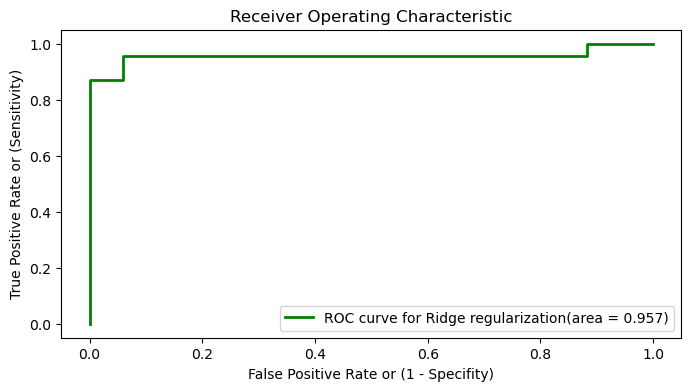

0.9565217391304348


In [18]:
def ridge_area_under_curve(model_R, x_test: np.ndarray, y_test: np.ndarray) -> float:
    '''
        return area under the curve measurements of trained Ridge model used to find coefficients, i.e., model tarined with optimal_aplha
        Also plot the ROC Curve using false_positive_rate, true_positive_rate as x and y axes calculated from roc_curve
    '''
    y_pred = model_R.predict(x_test)
    auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    plt.figure(figsize=(8, 4))
    plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve for Ridge regularization(area = %0.3f)' % auc)
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return auc

ridge_auc = ridge_area_under_curve(model_ridge, X_test, y_test)
print(ridge_auc)

### A-10: Lasso Area Under Curve

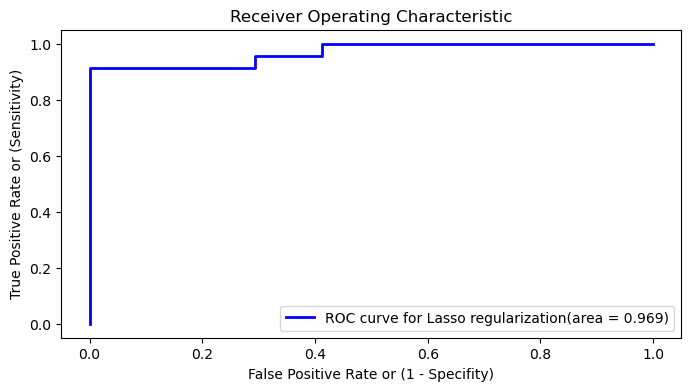

0.969309462915601


In [19]:
def lasso_area_under_curve(model_L, x_test: np.ndarray, y_test: np.ndarray) -> float:
    '''
        return area under the curve measurements of Lasso Model, i.e., model tarined with optimal_aplha
        Also plot the ROC Curve using false_positive_rate, true_positive_rate as x and y axes calculated from roc_curve
    '''
    y_pred = model_L.predict(x_test)
    auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
 
    plt.figure(figsize=(8, 4))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve for Lasso regularization(area = %0.3f)' % auc)
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return auc

lasso_auc = lasso_area_under_curve(model_lasso, X_test, y_test)
print(lasso_auc)

# Part B- Regression and Classification Trees

#### (1) Growing a maximum-depth regression tree

The recursive procedure for growing a deep regression tree is illustrated in the figure below. We begin (on the left) by fitting a stump to the original dataset. As we move from left to right the recursion proceeds, with each leaf of the preceding tree split in order to create the next, deeper tree. As can be seen in the rightmost panel, a tree with maximum depth of four is capable of representing the training data perfectly.  

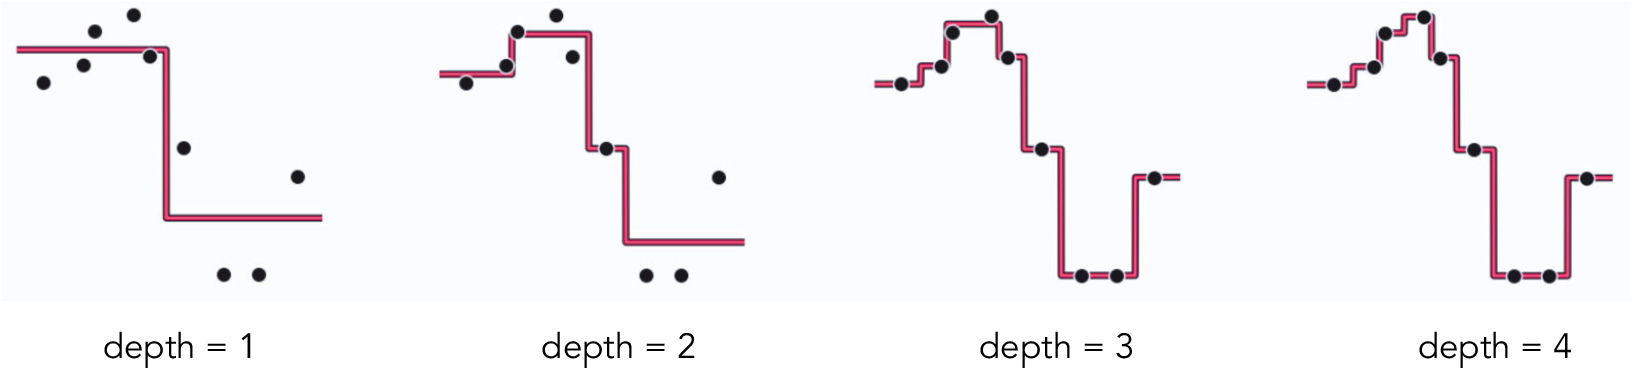

**Peform the experiment shown in the figure by coding up a recursively defined regression tree. Instead of reproducing the plot, measure and plot the mean squared error (MSE) at each depth of your tree.**

In [29]:
csvname = 'noisy_sin_subsample_2.csv' # Place the CSV file in the same directory as this notebook
data_regress = np.loadtxt(csvname, delimiter = ',')
data_regress = np.array([[x, y] for x,y in zip(*data_regress)])

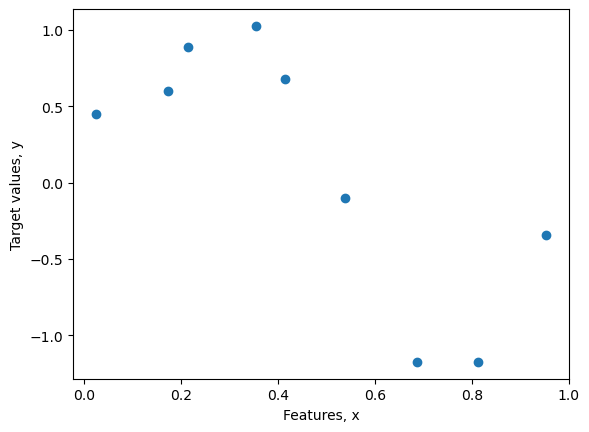

In [30]:
# Plot the data
plt.figure()
plt.scatter(data_regress[:, 0], data_regress[:, 1])
plt.xlabel("Features, x")
plt.ylabel("Target values, y")
plt.show()

**Build the regression tree in the `TreeRegressor` class**.  

In [117]:
class TreeRegressor():
    def __init__(self, data, max_depth=1):
        self.data = data
        self.max_depth = max_depth
        self.tree = None
        self.min_samples_split = 2 
        self.root_node = None

    # Build the recursive
    def build_tree(self):
        self.tree = self._build_tree(self.data, depth=0)

    def _build_tree(self, data, depth):
        n_samples, n_features = data.shape
        if depth >= self.max_depth or n_samples < self.min_samples_split:
            return np.mean(data[:, -1])
        best_split = self.find_best_split(data)
        if best_split is None:
            return np.mean(data[:, -1])
        left_data, right_data = best_split["left"], best_split["right"]
        feature_index, threshold = best_split["feature"], best_split["threshold"]

        decision_node = {
            "feature": feature_index,
            "threshold": threshold,
            "left": self._build_tree(left_data, depth + 1),
            "right": self._build_tree(right_data, depth + 1),
        }

        return decision_node
    def find_best_split(self, data):
        n_samples, n_features = data.shape
        best_mse = float('inf')
        best_split = None

        for feature_index in range(n_features - 1):  # Exclude the target variable
            for row in data:
                threshold = row[feature_index]
                left_mask = data[:, feature_index] <= threshold
                right_mask = data[:, feature_index] > threshold

                left_data = data[left_mask]
                right_data = data[right_mask]

                if len(left_data) == 0 or len(right_data) == 0:
                    continue

                splits = {"left": left_data, "right": right_data}
                mse = self.mean_squared_error(splits)

                if mse < best_mse:
                    best_mse = mse
                    best_split = {
                        "feature": feature_index,
                        "threshold": threshold,
                        "left": left_data,
                        "right": right_data,
                    }

        return best_split

    # Calculate the mean squared error for a split dataset
    def mean_squared_error(self, splits):
        left_data, right_data = splits["left"], splits["right"]
        left_target = left_data[:, -1]
        right_target = right_data[:, -1]

        left_mean = np.mean(left_target)
        right_mean = np.mean(right_target)

        left_mse = np.mean((left_target - left_mean) ** 2)
        right_mse = np.mean((right_target - right_mean) ** 2)

        mse = (len(left_data) / len(splits)) * left_mse + (len(right_data) / len(splits)) * right_mse
        return mse
    def predict(self, x_test):
        predictions = []
        for data_point in x_test:
            prediction = self._predict(data_point, self.tree)
            predictions.append(prediction)
        return predictions

    def _predict(self, data_point, node):
        if isinstance(node, dict):
            feature_index = node["feature"]
            threshold = node["threshold"]

            if data_point[feature_index] <= threshold:
                return self._predict(data_point, node["left"])
            else:
                return self._predict(data_point, node["right"])
        else:
            return node

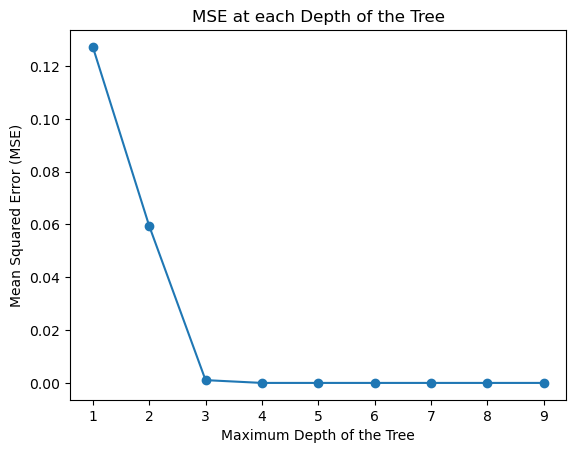

In [118]:
X = data_regress[:, :-1]
y = data_regress[:, -1]

max_depths, mse = [], []

for depth in range(1, 10):
    regression_tree = TreeRegressor(data_regress, max_depth=depth)
    regression_tree.build_tree()
    y_pred = regression_tree.predict(X)
    mse_depth = np.mean((y - y_pred)**2)
    max_depths.append(depth)
    mse.append(mse_depth)

plt.figure()
plt.plot(max_depths, mse, marker='o')
plt.xlabel('Maximum Depth of the Tree')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE at each Depth of the Tree')
plt.show()

### Growing a two-class classification tree

The figure below shows the growth of a tree to a maximum depth of seven on a two-class classification dataset. As the tree grows, note how many parts of the input space do not change as leaves on the deeper branches become *pure*. By the time we reach a maximum depth of seven, there is considerable overfitting.

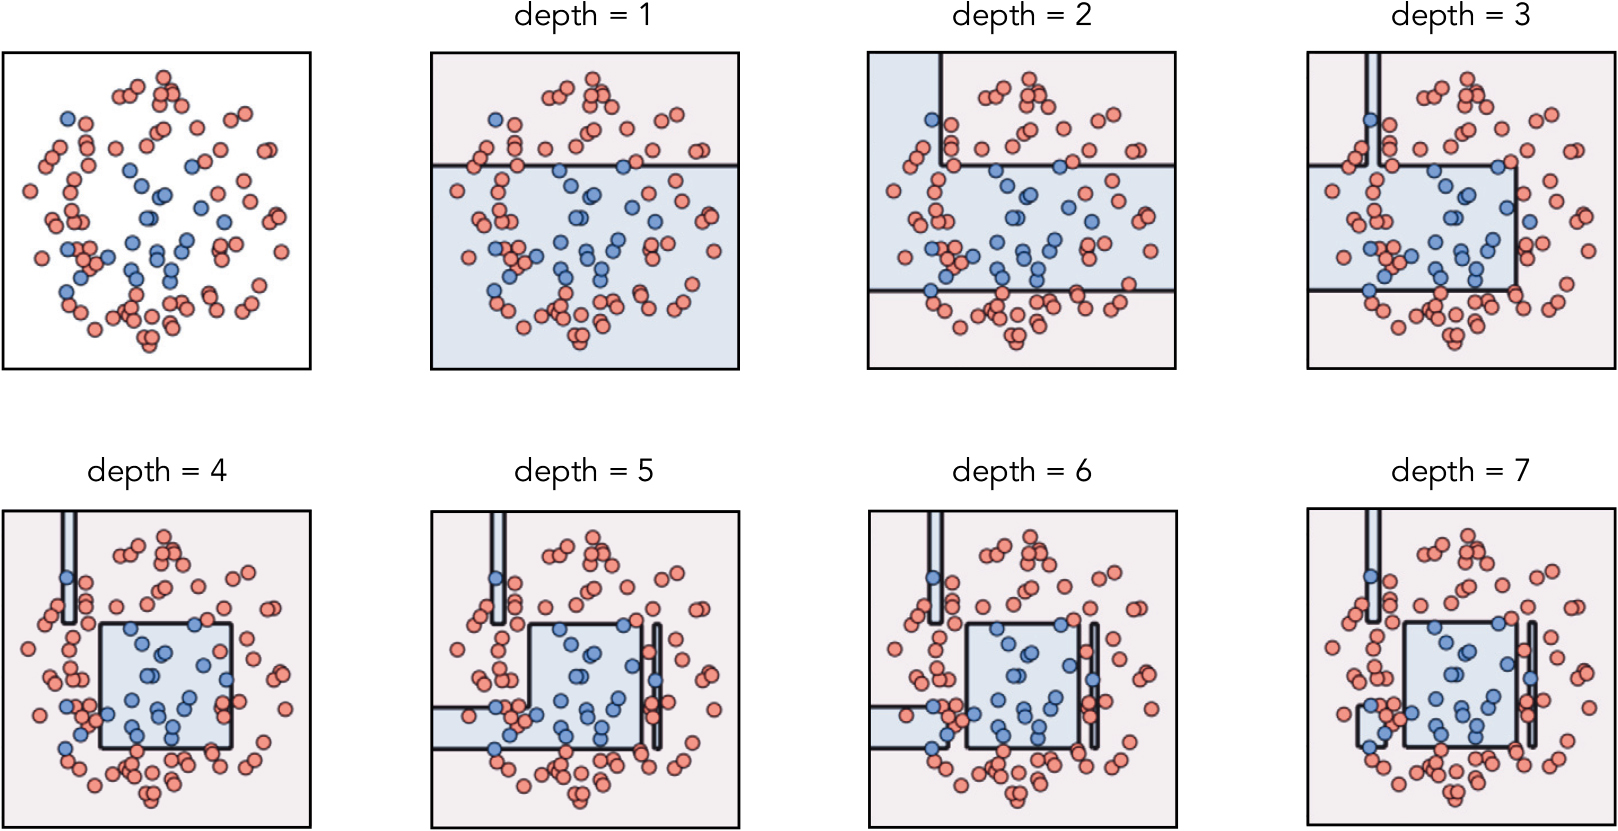

**Perform the experiment shown in figure by coding up a recursively defined two-class classification tree. Instead of reproducing the plot, measure and plot the classification accuracy at each depth of your tree.**

In [71]:
csvname = 'new_circle_data.csv' # Place the CSV file in the same directory as this notebook
data_class = np.loadtxt(csvname, delimiter = ',')
data_class = np.array([[x1, x2, y] for x1,x2,y in zip(*data_class)])

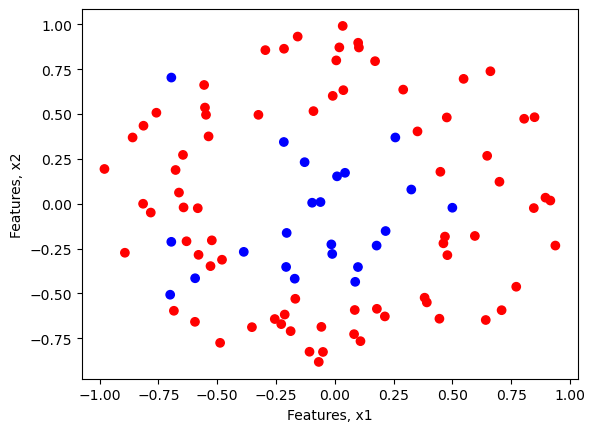

In [72]:
# Plot the data
plt.figure()
plt.scatter(data_class[:, 0], data_class[:, 1], c=-data_class[:, 2], cmap='bwr')
plt.xlabel("Features, x1")
plt.ylabel("Features, x2")
plt.show()

**Plot the classification accuracy at each depth of your tree.**

In [119]:
class TreeClassifier(TreeRegressor):
    def build_tree(self):
        self.tree = self._build_tree(self.data, depth=0)

    def _build_tree(self, data, depth):
        n_samples, n_features = data.shape

        if depth >= self.max_depth or n_samples < self.min_samples_split:
            # Implement the classification logic here
            class_labels = data[:, -1]
            positive_count = np.sum(class_labels == 1)
            negative_count = np.sum(class_labels == -1)
            
            if positive_count >= negative_count:
                predicted_class = 1
            else:
                predicted_class = -1

            return predicted_class

        best_split = self.find_best_split(data)

        if best_split is None:
            # Implement the classification logic here
            class_labels = data[:, -1]
            positive_count = np.sum(class_labels == 1)
            negative_count = np.sum(class_labels == -1)
            
            if positive_count >= negative_count:
                predicted_class = 1
            else:
                predicted_class = -1

            return predicted_class

        left_data, right_data = best_split["left"], best_split["right"]
        feature_index, threshold = best_split["feature"], best_split["threshold"]

        decision_node = {
            "feature": feature_index,
            "threshold": threshold,
            "left": self._build_tree(left_data, depth + 1),
            "right": self._build_tree(right_data, depth + 1),
        }

        return decision_node
    def gini_index(self, splits):
        gini = 0.0
        total_samples = sum(len(split) for split in splits)

        for split in splits:
            size = len(split)
            if size == 0:
                continue
            
            class_labels = split[:, -1]
            positive_count = np.sum(class_labels == 1)
            negative_count = np.sum(class_labels == -1)
            
            prob_positive = positive_count / size
            prob_negative = negative_count / size
            
            gini_split = 1.0 - (prob_positive ** 2 + prob_negative ** 2)
            gini += (size / total_samples) * gini_split

        return gini

    def find_best_split(self, data):
        n_samples, n_features = data.shape
        best_gini = 1.0  # Initialize the best Gini index to the worst case
        best_split = None

        for feature_index in range(n_features - 1):  # Exclude the target variable
            for row in data:
                threshold = row[feature_index]
                left_mask = data[:, feature_index] <= threshold
                right_mask = data[:, feature_index] > threshold

                left_data = data[left_mask]
                right_data = data[right_mask]

                if len(left_data) == 0 or len(right_data) == 0:
                    continue

                splits = {"left": left_data, "right": right_data}
                gini = self.gini_index(list(splits.values()))

                if gini < best_gini:
                    best_gini = gini
                    best_split = {
                        "feature": feature_index,
                        "threshold": threshold,
                        "left": left_data,
                        "right": right_data,
                    }

        return best_split

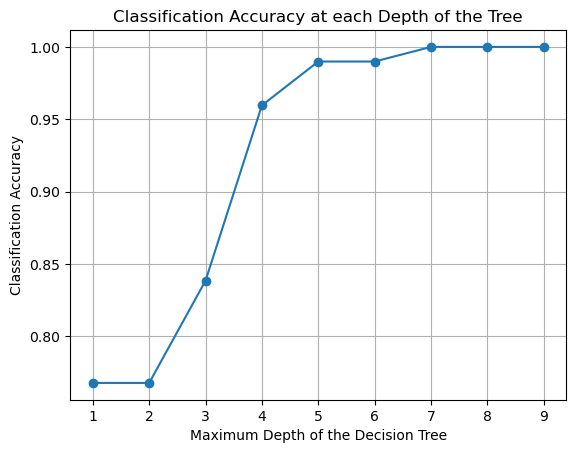

In [121]:
X = data_class[:, :-1]
y = data_class[:, -1]

max_depths, classification_accuracy_values = [], []

for depth in range(1, 10):
    classification_tree = TreeClassifier(data_class, max_depth=depth)
    classification_tree.build_tree()
    y_pred = classification_tree.predict(X)
    correct_preds = np.sum(y == y_pred)
    total_preds = len(y)
    classification_accuracy = correct_preds/total_preds
    max_depths.append(depth)
    classification_accuracy_values.append(classification_accuracy)

plt.figure()
plt.plot(max_depths, classification_accuracy_values, marker='o')
plt.xlabel('Maximum Depth of the Decision Tree')
plt.ylabel('Classification Accuracy')
plt.title('Classification Accuracy at each Depth of the Tree')
plt.grid(True)
plt.show()

## Part C - Boosting:

### C-1: Train an XGBoost classifier

In [21]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/11/6f/419545a6a344cfd1358a80c36a06431881d607830483ef63d7c38905cd22/xgboost-2.0.1-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.7 MB ? eta -:--:--
   ---------------------------------------- 0.1/99.7 MB 2.6 MB/s eta 0:00:38
   ---------------------------------------- 0.4/99.7 MB 4.1 MB/s eta 0:00:25
   ---------------------------------------- 0.6/99.7 MB 4.3 MB/s eta 0:00:23
   ---------------------------------------- 0.9/99.7 MB 4.9 MB/s eta 0:00:21
    --------------------------------------- 1.3/99.7 MB 5.7 MB/s eta 0:00:18
    --------------------------------------- 2.0/99.7 MB 7.0 MB/s eta 0:00:15
   - -------------------------------------- 3.0/99.7 MB 9.7 MB/s eta 0:00:10
   - -------------------------------------

In [5]:
import xgboost as xgb

def train_XGBoost( x_train: np.ndarray, y_train:np.ndarray, x_val: np.ndarray, y_val: np.ndarray)-> dict:
    '''
        Instantiate an object of XGBoost, train the model object using training data for the given N-bootstraps iterations.
        In each iteration train the model for all alpha_vals, compute the auc values with the validation set and append the values to aucs_xgboost.
        Return the "xgboost_mean_auc" dictionary which stores the mean auc for each alpha.
    '''
    n_bootstraps = int(1e2)
    alpha_vals = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]
    aucs_xgboost = {alpha: [] for alpha in alpha_vals}

    for _ in range(n_bootstraps):
        for alpha in alpha_vals:
            xgboost_model = xgb.XGBClassifier(alpha=alpha)
            xgboost_model.fit(x_train, y_train)
            y_pred = xgboost_model.predict_proba(x_val)[:, 1]
            auc = roc_auc_score(y_val, y_pred)
            aucs_xgboost[alpha].append(auc)

    xgboost_mean_auc = {alpha: np.mean(aucs) for alpha, aucs in aucs_xgboost.items()}
    return xgboost_mean_auc
 
model_xgboost_mean = train_XGBoost(X_train, y_train, X_val, y_val)
print(model_xgboost_mean)

{0.001: 0.9836956521739131, 0.01: 0.9836956521739131, 0.1: 0.9836956521739131, 1: 0.9782608695652171, 10.0: 0.9673913043478263, 100.0: 0.5, 1000.0: 0.5}


### C-2: Train the model with the best alpha.

In [7]:
optimal_alpha_model_xgboost = max(model_xgboost_mean, key=lambda k: model_xgboost_mean[k])
model_xgboost = xgb.XGBClassifier(alpha=optimal_alpha_model_xgboost)
model_xgboost.fit(X_train, y_train)

XGBClassifier(alpha=0.001, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

### C-3: Plot the ROC curve

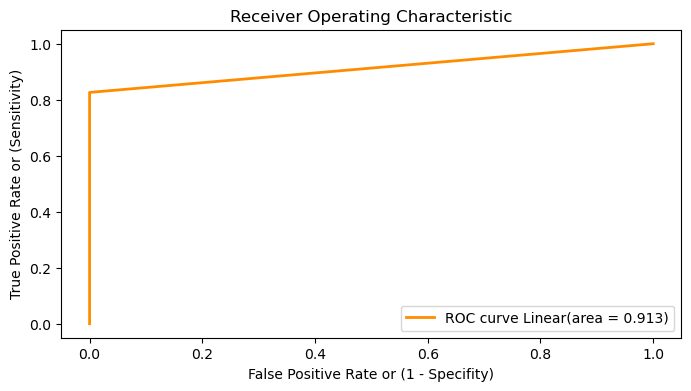

0.9130434782608696


In [8]:
def xgboost_area_under_curve(model_XGB, x_test: np.ndarray, y_test: np.ndarray) -> float:
    '''
        return area under the curve measurements of XGBoost Model, i.e., model tarined with optimal_aplha
        Also plot the ROC Curve using false_positive_rate, true_positive_rate as x and y axes calculated from roc_curve
    '''
    y_pred = model_XGB.predict(x_test)
    auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
 
    plt.figure(figsize=(8, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve for XGBoost(area = %0.3f)' % auc)
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return auc

xgboost_auc = xgboost_area_under_curve(model_xgboost, X_test, y_test)
print(xgboost_auc)

#### Compare the results of the XGBoost model with the Ridge and the Lasso models and report your findings.

In comparing the performance of the Ridge (L2), Lasso (L1), and XGBoost models, I observed distinct differences in their AUC scores. The AUC scores for the models are as follows: L2 : 0.956, L1 : 0.969, and XGBoost : 0.913.

First, the Lasso (L1) model stands out with the highest AUC score of 0.969. This result suggests that the Lasso model has the best discriminative power for the given dataset. The fact that Lasso introduces feature selection by reducing some coefficients to zero aligns with this strong performance, indicating that it effectively captures the most relevant features for classification.

Next, the Ridge (L2) model, with an AUC of 0.956, showcases a slightly lower but still respectable performance. Ridge regularization is known for its ability to retain all features while minimizing their weights. In this context, it generalizes the model effectively, although not as stringently as Lasso in terms of feature selection.

Finally, the XGBoost model, with an AUC of 0.913, exhibits the lowest performance among the three. While XGBoost is a powerful ensemble technique and versatile in various scenarios, these specific results indicate that for this dataset, linear models like Ridge and Lasso outperform XGBoost in terms of AUC.